In [1]:
import numpy as np
import ROOT as rt

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('olmo')

from histo_utilities import create_TH1D, create_TH2D
from cebefo_style import cebefo_style
cebefo_style()

c_light = 2.99792458E8 #m/s

!cd /Users/olmo/programs/Delphes-3.4.1
rt.gSystem.Load("libDelphes");
rt.gInterpreter.Declare('#include "classes/DelphesClasses.h"');
rt.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"');

Welcome to JupyROOT 6.10/08


In [3]:
file_path = ['/Users/olmo/cernbox/PID_timing_studies/_root/jobs_PtStudies/pp2RHad_PU0_M100/merge.root']

chain = rt.TChain('Delphes')
for path in file_path:
    chain.Add(path)
    
chain.Print()

treeReader = rt.ExRootTreeReader(chain)
numberOfEntries = treeReader.GetEntries()

branches_names = ['Event', 'Particle', 'Track','Vertex4D', 'GenVertex']
branch = {}

for b in branches_names:
    branch[b] = treeReader.UseBranch(b)

******************************************************************************
*Chain   :Delphes   : /Users/olmo/cernbox/PID_timing_studies/_root/jobs_PtStudies/pp2RHad_PU0_M100/merge.root *
******************************************************************************
******************************************************************************
*Tree    :Delphes   : Analysis tree                                          *
*Entries :    25000 : Total =      1438632563 bytes  File  Size =  576410442 *
*        :          : Tree compression factor =   2.50                       *
******************************************************************************
*Br    0 :Event     : Int_t Event_                                           *
*Entries :    25000 : Total  Size=     217192 bytes  File Size  =      33920 *
*Baskets :       20 : Basket Size=      64000 bytes  Compression=   5.95     *
*............................................................................*
*Br    1 :Event.fUn

In [4]:
tks_names = ['Nev','DzOF','DtOF', 'IsPU', 'M', 'TOF_MC', 'P', 'CtgTheta','L','M_reco']
tks_att = []

for i in range(numberOfEntries):
    treeReader.ReadEntry(i)
    
    Nev = i
        
    for j in range(branch['Track'].GetEntries()):
        track = branch['Track'].At(j)
        if track.VertexIndex == -1: continue
        vtx = branch['Vertex4D'].At(track.VertexIndex)
        
        p = track.Particle.GetObject()
        beta_MC = p.P/p.E
        
        TOF_MC = 1E12*(track.L*1E-3/(c_light*beta_MC))
        
        DtOF = 1E12*(track.TOuter - vtx.T)
        
        DzOF = track.ZOuter - vtx.Z
        
        IsPU = p.IsPU
        
        M = p.Mass
        
        M_reco = track.Mass
        
        P = track.P
        
        CtgTheta = track.CtgTheta
        
        L = track.L
        
        tks_att.append((Nev,DzOF,DtOF, IsPU, M, TOF_MC, P, CtgTheta, L, M_reco))
    

tks = np.array(tks_att, dtype=zip(tks_names,['<f8']*len(tks_names)))
print tks.size

919484


In file included from ClassesDict dictionary payload:34:
/Users/olmo/programs/Delphes-3.4.1/classes/DelphesModule.h:30:10: fatal error: 'ExRootAnalysis/ExRootTask.h' file not found
#include "ExRootAnalysis/ExRootTask.h"
         ^
Error in <TInterpreter::AutoParse>: Error parsing payload code for class Track with content:

#line 1 "ClassesDict dictionary payload"

#ifndef G__VECTOR_HAS_CLASS_ITERATOR
  #define G__VECTOR_HAS_CLASS_ITERATOR 1
#endif

#define _BACKWARD_BACKWARD_WARNING_H
/*
 *  Delphes: a framework for fast simulation of a generic collider experiment
 *  Copyright (C) 2012-2014  Universite catholique de Louvain (UCL), Belgium
 *
 *  This program is free software: you can redistribute it and/or modify
 *  it under the terms of the GNU General Public License as published by
 *  the Free Software Foundation, either version 3 of the License, or
 *  (at your option) any later version.
 *
 *  This program is distributed in the hope that it will be useful,
 *  but WITHOUT ANY WA

 FCN=92.2458 FROM MIGRAD    STATUS=CONVERGED     110 CALLS         111 TOTAL
                     EDM=2.97404e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.44334e-01   8.47298e-04   3.14030e-06  -1.15118e-02
   2  p1           5.66506e+00   3.20011e-02   1.43811e-04  -3.15470e-07
   3  p2           3.23727e+01   3.88685e-02   1.42708e-04   1.48402e-04


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::SaveAs>: ROOT file /Users/olmo/Desktop/TOF_resolution.root has been created


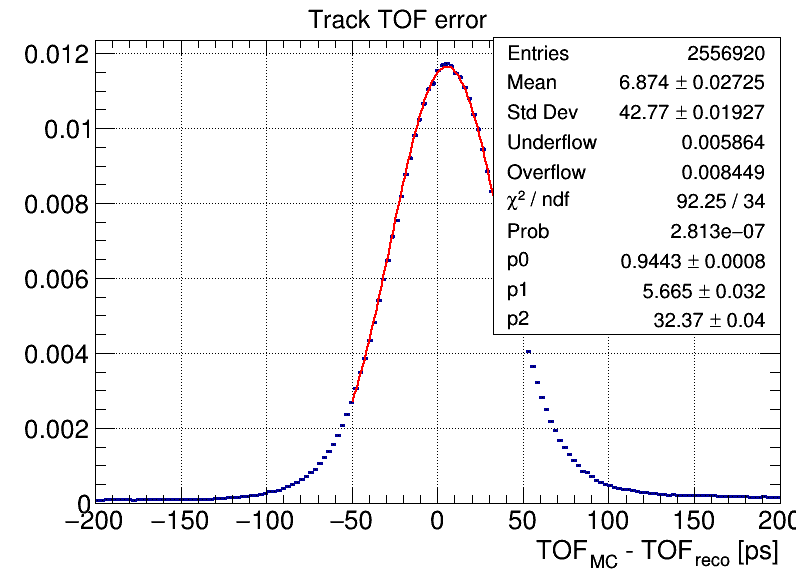

In [10]:
sel = tks['P'] > 0
dTOF = tks['TOF_MC'][sel] - tks['DtOF'][sel]
h = create_TH1D(dTOF, title = 'Track TOF error', binning = [151, -200, 200])
h.Scale(1./h.Integral("width"))
h.SetXTitle('TOF_{MC} - TOF_{reco} [ps]')
f1 = rt.TF1('f_fit', '[0]*TMath::Gaus(x, [1], [2], 1)',-50,50)
f1.SetParameters(0.3, 0.1, 50,-0.1, 200)
h.Fit('f_fit','R')

c = rt.TCanvas('c','c',800,600)
h.Draw()
# c.SetLogy()
c.Draw()

c.SaveAs('~/Desktop/TOF_resolution.root')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::SaveAs>: ROOT file /Users/olmo/Desktop/TOF_resolution_sep.root has been created


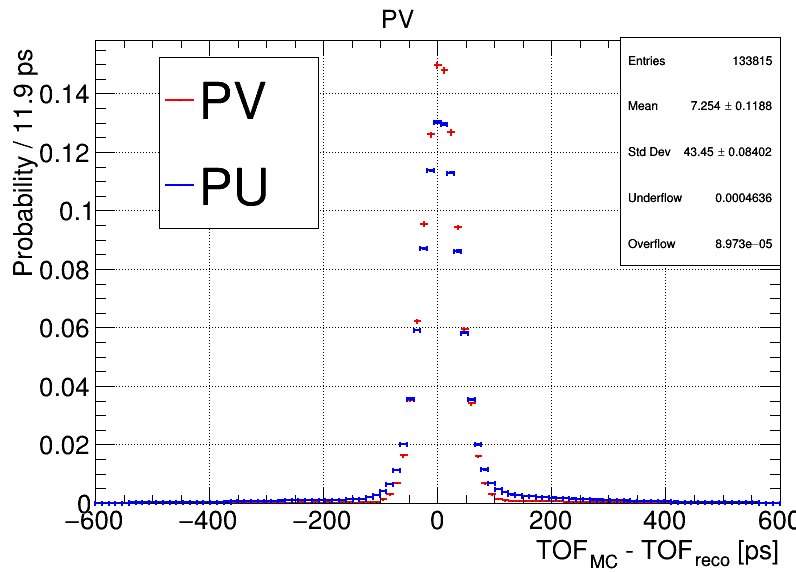

In [5]:
c = rt.TCanvas('c','c',800,600)
histos = []

h = create_TH1D(dTOF[tks['IsPU']==0], name='PV', title='PV', binning = [101, -600, 600])
h.SetXTitle('TOF_{MC} - TOF_{reco} [ps]')
h.SetYTitle('Probability / {:.1f} ps'.format(h.GetBinWidth(1)))
h.Scale(1./h.Integral())
h.SetLineColor(2)
h.SetLineWidth(2)
h.DrawCopy('')

h = create_TH1D(dTOF[tks['IsPU']==1], name='PU', title='PU', binning = [101, -600, 600])
if h.Integral()>0:
    h.Scale(1./h.Integral())
h.SetLineColor(4)
h.SetLineWidth(2)
h.DrawCopy('E1same')

c.BuildLegend(0.2, 0.6,0.4,0.9)
# c.SetLogy()
# c.SetLogx()
c.Draw()

c.SaveAs('~/Desktop/TOF_resolution_sep.root')

Grafico 2D Beta vs P

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h2D (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /Users/olmo/Desktop/beta_vs_p.root has been created


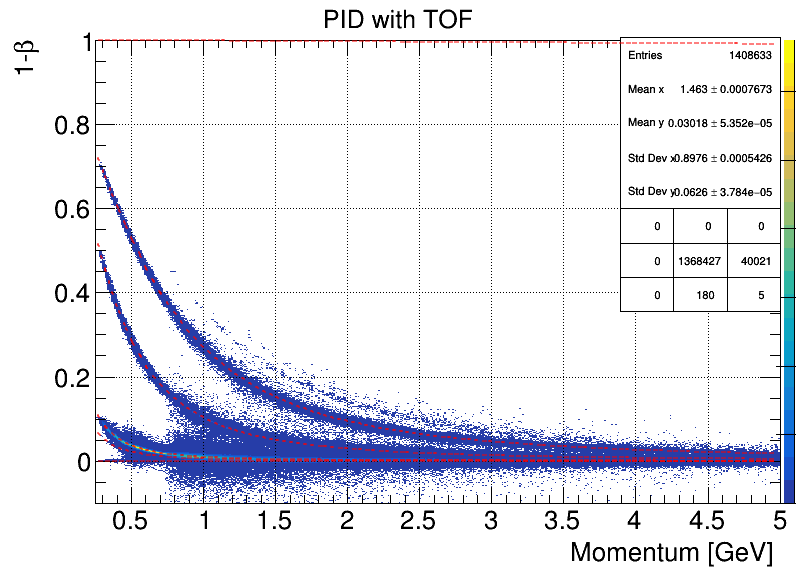

In [9]:
beta = np.sqrt(1 + 1./np.square(tks['CtgTheta']) ) * tks['DzOF']*1E-3/(c_light*1E-12*tks['DtOF'])
beta = tks['L']/(c_light*1E-9*tks['DtOF'])
beta = np.abs(beta)

eta = np.arcsinh(tks['CtgTheta'])

P_limits = [0.25, 5]

c = rt.TCanvas('c','c',800,600)

h2D = create_TH2D(np.column_stack((tks['P'], 1-beta))[np.abs(eta)<1.5], 'h2D', 'PID with TOF', binning = [500, P_limits[0], P_limits[1], 500, -0.1, 1])
h2D.SetYTitle('1-#beta')
h2D.SetXTitle('Momentum [GeV]')
h2D.Draw('colz')

f_par = {'pi': 0.139570**2, 'kaon': 0.493**2, 'proton': 0.938**2, 'muon': 0.105**2, 'electron': 0.000511**2, 'RHad': 500**2}
for n, m2 in f_par.items():
    f_par[n] = rt.TF1('f_'+n, '1 - x/sqrt(x*x + {})'.format(m2), P_limits[0], P_limits[1])
    f_par[n].SetLineColorAlpha(2, 0.5)
    f_par[n].SetLineStyle(7)
    f_par[n].Draw('same')

# c.SetLogy()
# c.SetLogx()
c.Draw()

c.SaveAs('~/Desktop/beta_vs_p.root')

Grafico Estimated mass

Warning in <TROOT::Append>: Replacing existing TH1: h_mass (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::SaveAs>: ROOT file /Users/olmo/Desktop/Estimated_mass_spectrum.root has been created


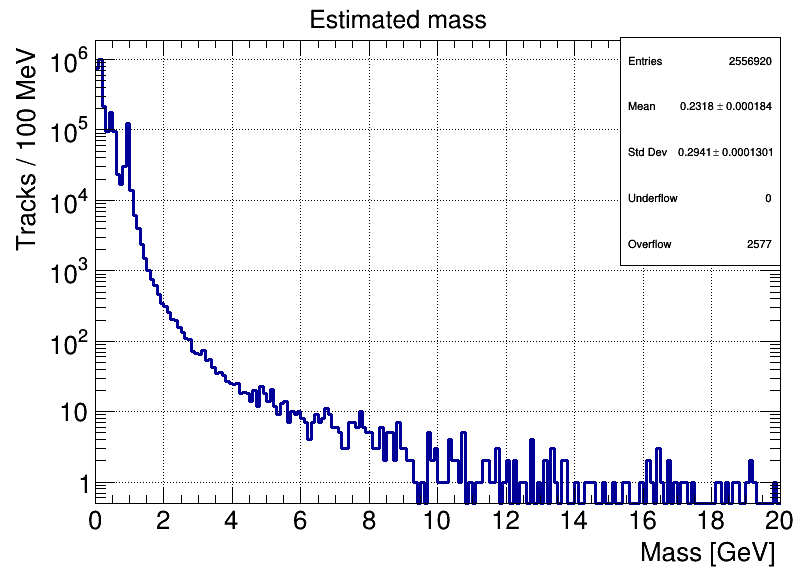

In [12]:
mass_reco = tks['P']*np.sqrt(1./np.square(np.minimum(beta,np.ones_like(beta))) - 1)

h = create_TH1D(mass_reco, 'h_mass', 'Estimated mass', binning = [200, 0, 20])
h.SetXTitle('Mass [GeV]')
h.SetYTitle('Tracks / {:.0f} MeV'.format(1000*h.GetBinWidth(1)))
c = rt.TCanvas('c','c',800,600)
h.Draw()

c.SetLogy()
c.Draw()

c.SaveAs('~/Desktop/Estimated_mass_spectrum.root')